In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl'
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl'
# !pip install effdet

Processing /kaggle/input/timm-package/timm-0.1.26-py3-none-any.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Processing /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")

import json
import numpy as np
import pandas as pd
import cv2
import os
import re
from datetime import datetime
import time
import random

from PIL import Image
from tqdm import tqdm
from glob import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from sklearn.model_selection import StratifiedKFold


from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.DataFrame(columns = ['id','x1','y1','x2','y2','classname'])
idx = 0
for dirname, _, filenames in os.walk('../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations'):
    for filename in filenames:
        d = json.load(open(os.path.join(dirname, filename)))
        id = d['FileName']
        for l in d['Annotations']:
            df.loc[idx , :] = [id] + l['BoundingBox'] + [l['classname']]
            idx += 1
class_map = dict(zip(df['classname'].unique(),list(range(1,21))))
print(df['classname'].unique())
pd.DataFrame(df['classname'].unique(),columns = ['classname']).to_csv('classname.csv',index=False)
df['class'] = df['classname'].apply(lambda x : class_map[x])
# df['id'] = df['id'].astype(np.str)
df[['x1','y1','x2','y2']] = df[['x1','y1','x2','y2']].astype(np.float)
df = df.drop(index = df[df['x1']==df['x2']].index)
df.to_csv('train.csv',index=False)
# df = pd.read_csv('../input/facemask/train.csv')
df

['face_no_mask' 'face_with_mask' 'mask_colorful' 'face_other_covering'
 'face_shield' 'mask_surgical' 'hat' 'eyeglasses' 'sunglasses' 'helmet'
 'goggles' 'face_with_mask_incorrect' 'scarf_bandana' 'hair_net'
 'hijab_niqab' 'hood' 'turban' 'other' 'balaclava_ski_mask' 'gas_mask']


,id,x1,y1,x2,y2,classname,class
0,5799.jpg,64.0,0.0,539.0,590.0,face_no_mask,1
1,2864.png,260.0,5.0,424.0,173.0,face_with_mask,2
2,2864.png,268.0,16.0,383.0,158.0,mask_colorful,3
3,5407.jpg,234.0,129.0,618.0,625.0,face_other_covering,4
4,5407.jpg,171.0,210.0,597.0,687.0,face_shield,5
...,...,...,...,...,...,...,...
15407,3125.png,191.0,21.0,291.0,94.0,hair_net,14
15408,3125.png,457.0,83.0,511.0,133.0,hair_net,14
15409,3125.png,242.0,88.0,303.0,119.0,goggles,11
15410,3282.png,198.0,0.0,542.0,428.0,face_with_mask,2


In [4]:
# df = pd.read_csv('../input/facemask/FaceMask.csv')
# df = df.rename(columns = {'classname':'class'})
# df

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['id']].copy()
df_folds.loc[:, 'bbox_count'] = 0
df_folds = df_folds.groupby('id').count()
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds.bbox_count)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
    
# df_folds.to_csv('train_folds.csv',index=False)
# df_folds = pd.read_csv('../input/facemask/train_folds.csv')
df_folds

,bbox_count,fold
id,,
1801.jpg,1,3
1802.jpg,2,2
1803.jpg,2,3
1804.jpg,2,4
1805.jpg,3,0
...,...,...
6431.png,2,3
6432.jpg,5,0
6433.png,11,0


In [6]:
def get_train_transforms():
    return A.Compose(
        [
#             A.RandomSizedCrop(min_max_height=(256, 256), height=1024, width=1024, p=0.5),
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.01),
            A.Resize(height=512, width=512, p=1),
            A.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
            A.Cutout(num_holes=20, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            A.Blur(blur_limit=5, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625,scale_limit=0.1, rotate_limit=20 ,p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [7]:
TRAIN_ROOT_PATH = '../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image, boxes, labels = self.load_image_and_boxes(index)
        
#         if self.test or random.random() > 0.5:
#             image, boxes = self.load_image_and_boxes(index)
#         else:
#             image, boxes = self.load_cutmix_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target['labels']
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.tensor(sample['labels'])
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['id'] == image_id]
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        return image, boxes , records['class']

#     def load_cutmix_image_and_boxes(self, index, imsize=1024):
#         """ 
#         This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
#         Refactoring and adaptation: https://www.kaggle.com/shonenkov
#         """
#         w, h = imsize, imsize
#         s = imsize // 2
    
#         xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
#         indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

#         result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
#         result_boxes = []

#         for i, index in enumerate(indexes):
#             image, boxes = self.load_image_and_boxes(index)
#             if i == 0:
#                 x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
#                 x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
#             elif i == 1:  # top right
#                 x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
#                 x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
#             elif i == 2:  # bottom left
#                 x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
#                 x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
#             elif i == 3:  # bottom right
#                 x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
#                 x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
#             result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
#             padw = x1a - x1b
#             padh = y1a - y1b

#             boxes[:, 0] += padw
#             boxes[:, 1] += padh
#             boxes[:, 2] += padw
#             boxes[:, 3] += padh

#             result_boxes.append(boxes)

#         result_boxes = np.concatenate(result_boxes, 0)
#         np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
#         result_boxes = result_boxes.astype(np.int32)
#         result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
#         return result_image, result_boxes

In [8]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=df,
    transforms=get_valid_transforms(),
    test=True,
)

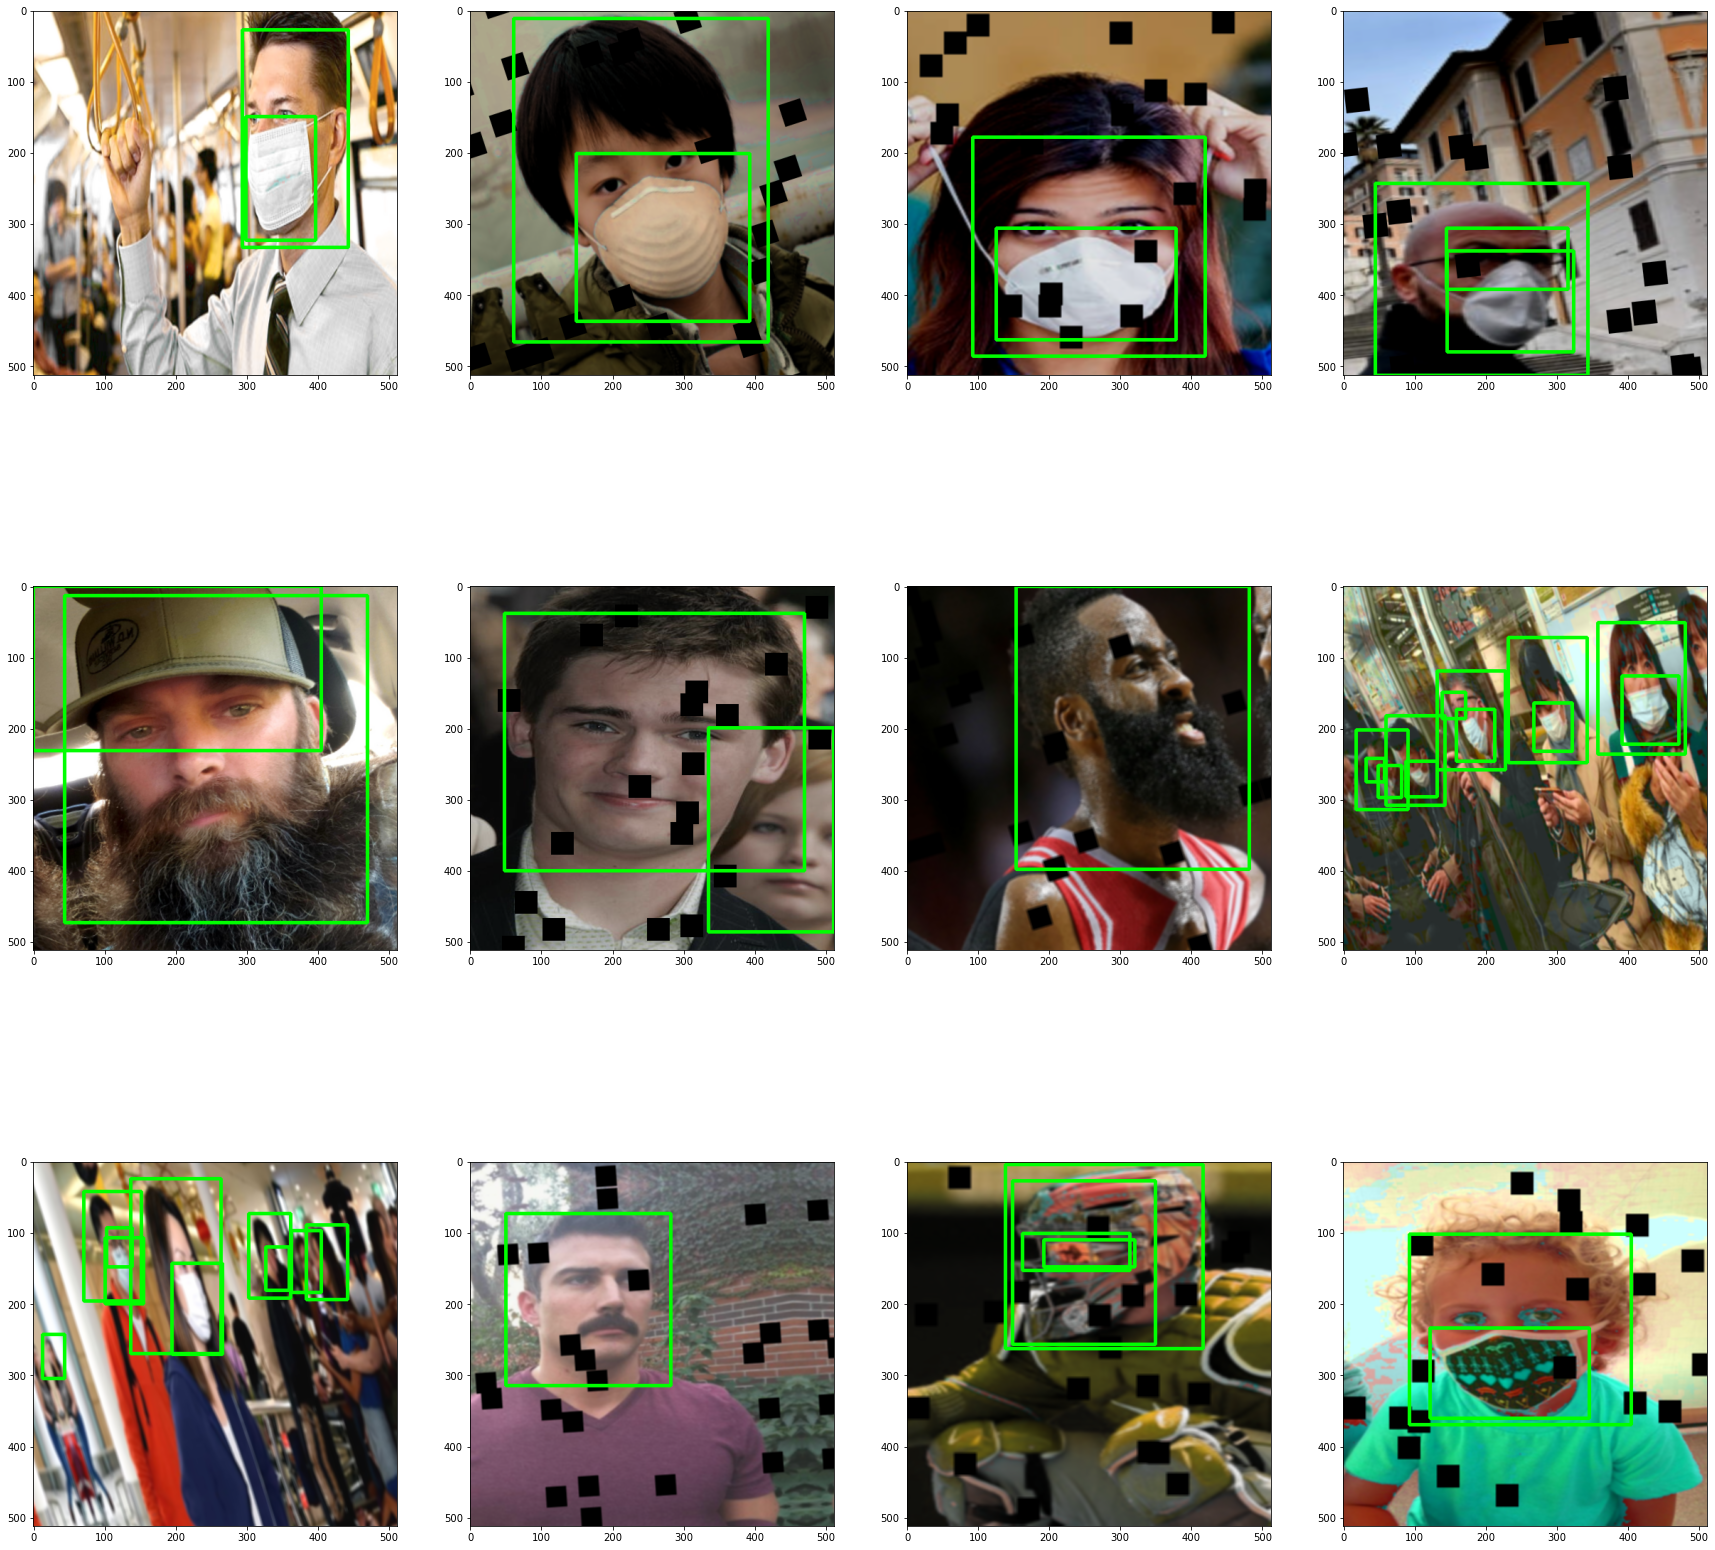

In [9]:
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 3

c_map = dict(zip(list(range(1,21)),pd.read_csv('../input/facemask/classname.csv')['classname'].unique()))

for i in range(1, columns*rows +1):
    image, target, image_id = train_dataset[i]
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    classnames = target['labels'].cpu().numpy()
    numpy_image = image.permute(1,2,0).cpu().numpy()
    for j, box in enumerate(boxes):
        cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 255, 0), 3)
#         cv2.putText(numpy_image , c_map[classnames[j]] , (int(box[0]),int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(numpy_image)
plt.show()

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
class TrainGlobalConfig:
    num_workers = 8
    batch_size = 4
    n_epochs = 20
    lr = 0.001

    folder = 'effdet'
    verbose = True
    verbose_step = 1
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.25,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [12]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
        
#         self.load('../input/face-mask-efficientdet/effdet/last-checkpoint.bin')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'LR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        
        tk0 =  tqdm(enumerate(val_loader),total = len(validation_dataset)/TrainGlobalConfig.batch_size)
        for step, (images, targets, image_ids) in tk0:
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    tk0.set_postfix( loss = summary_loss.avg)
                    
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        
        tk0 =  tqdm(enumerate(train_loader),total = int(len(train_dataset)/TrainGlobalConfig.batch_size))
        for step, (images, targets, image_ids) in tk0:
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    tk0.set_postfix( loss = summary_loss.avg)
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
#         sampler=RandomSampler(train_dataset),
        shuffle=True,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
#         sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [14]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=True)
#     checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
#     net.load_state_dict(checkpoint)
    config.num_classes = 20
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


In [15]:
run_training()

Fitter prepared. Device is cuda:0
LR: 0.001


100%|██████████| 865/865 [11:34<00:00,  1.24it/s, loss=43.9]


[RESULT]: Train. Epoch: 0, summary_loss: 43.85503, time: 695.13569


217it [00:51,  4.20it/s, loss=1.3]


[RESULT]: Val. Epoch: 0, summary_loss: 1.29896, time: 52.04612
LR: 0.001


100%|██████████| 865/865 [11:33<00:00,  1.25it/s, loss=1.06]


[RESULT]: Train. Epoch: 1, summary_loss: 1.05611, time: 693.40337


217it [00:48,  4.43it/s, loss=0.884]


[RESULT]: Val. Epoch: 1, summary_loss: 0.88416, time: 49.35858
LR: 0.001


100%|██████████| 865/865 [11:24<00:00,  1.26it/s, loss=0.836]


[RESULT]: Train. Epoch: 2, summary_loss: 0.83609, time: 684.37560


217it [00:48,  4.47it/s, loss=0.746]


[RESULT]: Val. Epoch: 2, summary_loss: 0.74601, time: 48.95704
LR: 0.001


100%|██████████| 865/865 [11:20<00:00,  1.27it/s, loss=0.739]


[RESULT]: Train. Epoch: 3, summary_loss: 0.73940, time: 680.91000


217it [00:49,  4.34it/s, loss=0.665]


[RESULT]: Val. Epoch: 3, summary_loss: 0.66508, time: 50.29174
LR: 0.001


100%|██████████| 865/865 [11:26<00:00,  1.26it/s, loss=0.696]


[RESULT]: Train. Epoch: 4, summary_loss: 0.69588, time: 686.93111


217it [00:48,  4.49it/s, loss=0.661]


[RESULT]: Val. Epoch: 4, summary_loss: 0.66068, time: 48.76390
LR: 0.001


100%|██████████| 865/865 [11:24<00:00,  1.26it/s, loss=0.671]


[RESULT]: Train. Epoch: 5, summary_loss: 0.67079, time: 684.89711


217it [00:49,  4.37it/s, loss=0.683]

[RESULT]: Val. Epoch: 5, summary_loss: 0.68333, time: 49.99164
LR: 0.001



100%|██████████| 865/865 [11:36<00:00,  1.24it/s, loss=0.666]


[RESULT]: Train. Epoch: 6, summary_loss: 0.66618, time: 696.71106


217it [00:51,  4.22it/s, loss=0.638]


[RESULT]: Val. Epoch: 6, summary_loss: 0.63838, time: 51.72237
LR: 0.001


100%|██████████| 865/865 [11:42<00:00,  1.23it/s, loss=0.654]


[RESULT]: Train. Epoch: 7, summary_loss: 0.65448, time: 703.01172


217it [00:50,  4.26it/s, loss=0.586]


[RESULT]: Val. Epoch: 7, summary_loss: 0.58601, time: 51.32705
LR: 0.001


100%|██████████| 865/865 [11:42<00:00,  1.23it/s, loss=0.642]


[RESULT]: Train. Epoch: 8, summary_loss: 0.64160, time: 703.06356


217it [00:50,  4.30it/s, loss=0.579]


[RESULT]: Val. Epoch: 8, summary_loss: 0.57954, time: 50.91805
LR: 0.001


100%|██████████| 865/865 [11:42<00:00,  1.23it/s, loss=0.635]


[RESULT]: Train. Epoch: 9, summary_loss: 0.63526, time: 702.50973


217it [00:52,  4.16it/s, loss=0.571]


[RESULT]: Val. Epoch: 9, summary_loss: 0.57105, time: 52.53671
LR: 0.001


217it [00:51,  4.19it/s, loss=0.606]

[RESULT]: Val. Epoch: 11, summary_loss: 0.60615, time: 52.23543
LR: 0.001



217it [00:51,  4.19it/s, loss=0.531]


[RESULT]: Val. Epoch: 13, summary_loss: 0.53147, time: 52.23715
LR: 0.001


100%|██████████| 865/865 [11:52<00:00,  1.21it/s, loss=0.586]


[RESULT]: Train. Epoch: 14, summary_loss: 0.58658, time: 712.40288


217it [00:52,  4.12it/s, loss=0.578]

[RESULT]: Val. Epoch: 14, summary_loss: 0.57837, time: 53.03047
LR: 0.001



100%|██████████| 865/865 [11:50<00:00,  1.22it/s, loss=0.551]


[RESULT]: Train. Epoch: 17, summary_loss: 0.55053, time: 710.51791


217it [00:52,  4.14it/s, loss=0.526]

[RESULT]: Val. Epoch: 17, summary_loss: 0.52599, time: 52.75709
LR: 0.001



 71%|███████   | 610/865 [08:19<03:19,  1.28it/s, loss=0.553]